# DL Challenge

Team:
German Novykov
Alexiy Pidnebesnyi
Mark Vaykul

3 models, training our model from scratch, fine tuning, using tensorflow and pre trained models, as well as pytorch with google vit from Huggingface.


2st model fine tuning pre trained model ResNet

3st model Google vit. by far the strongest one but can recognise everything already

1st model, trained only on data provided in the challenge. 


In [183]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

Load the data with method **image_dataset_from_directory**

Images automatically are given classes based on folder names, ['Cat', 'Cheetah', 'Leopard', 'Lion', 'Tiger']

In [184]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Set the parameters for your data
batch_size = 32
image_size = (160,160)
validation_split = 0.2

# Create the training dataset from the 'train' directory
train_ds = image_dataset_from_directory(
    directory='./train/train',
    batch_size=batch_size,
    image_size=image_size,
    validation_split=validation_split,
    subset='training',
    seed=123
)

# Create the validation dataset from the 'train' directory
validation_ds = image_dataset_from_directory(
    directory='./train/train',
    batch_size=batch_size,
    image_size=image_size,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

test_ds = image_dataset_from_directory(
    directory='./test',
    batch_size=batch_size,
    image_size=image_size
)

class_names = train_ds.class_names
print(class_names)
print(train_ds)
for images, labels in train_ds.take(1):  # 'take(1)' takes just one batch from the dataset
    print("Shape of training images:", images.shape)  # Prints the shape of images
    print("Shape of training labels:", labels.shape)

Found 2026 files belonging to 5 classes.
Using 1621 files for training.
Found 2026 files belonging to 5 classes.
Using 405 files for validation.
Found 473 files belonging to 1 classes.
['Cat', 'Cheetah', 'Leopard', 'Lion', 'Tiger']
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Shape of training images: (32, 160, 160, 3)
Shape of training labels: (32,)


# EDA and Data Augmentation

Let's take a look at the data. We did Edge detection on the images and the best one looks like kernel 5x5 higher treshold The pictures are loaded with resolution of 64x64 

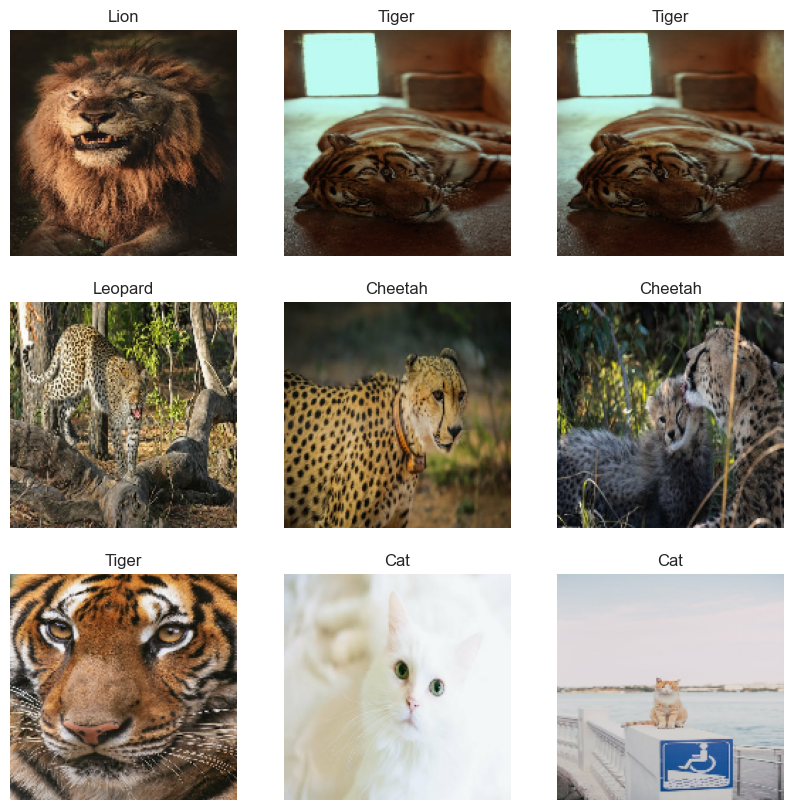

In [185]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

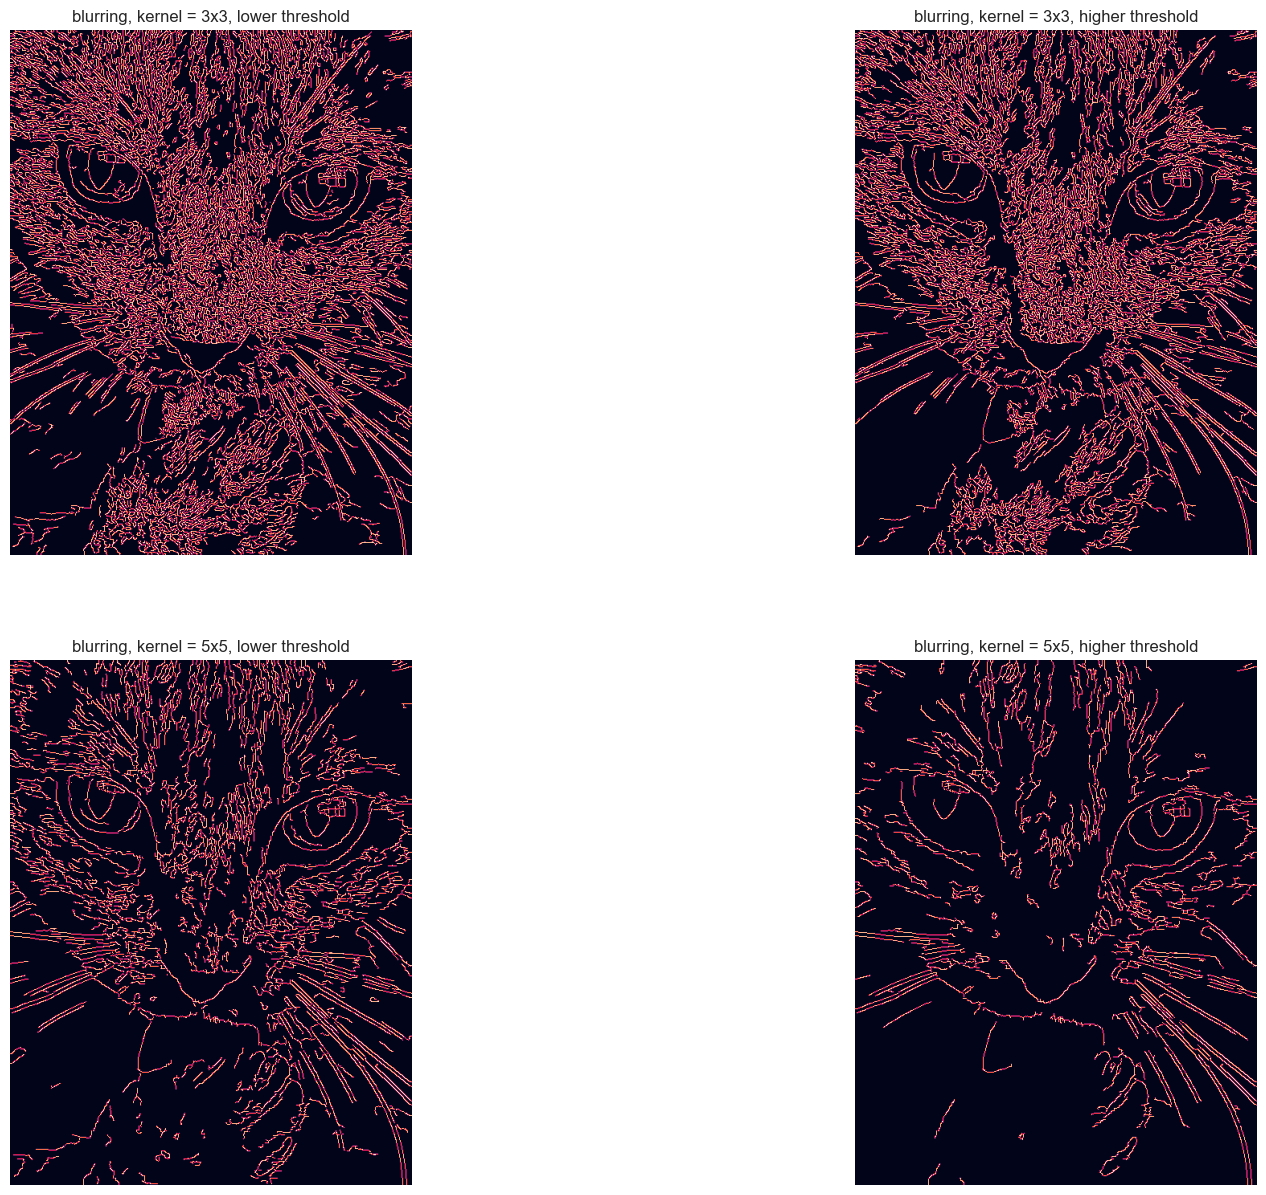

In [186]:
import cv2
img_orig = cv2.imread('./train/train/Cat/Cat_Cat91.jpg')

# set the lower and upper threshold
med_val = np.median(img_orig)
lower = int(max(0, .7 * med_val))
upper = int(min(255, 1.3 * med_val))

# blurring with ksize = 3
img_k3 = cv2.blur(img_orig, ksize = (3, 3))
# canny detection with different thresholds
edges_k3 = cv2.Canny(img_k3, threshold1 = lower, threshold2 = upper)
edges_k3_2 = cv2.Canny(img_k3, lower, upper + 75)

# blurring with ksize = 5 
img_k5 = cv2.blur(img_orig, ksize = (5, 5))
# canny detection with different thresholds
edges_k5 = cv2.Canny(img_k5, lower, upper)
edges_k5_2 = cv2.Canny(img_k5, lower, upper + 75)

# plot the images
images = [edges_k3, edges_k3_2, edges_k5, edges_k5_2]
titles = ['blurring, kernel = 3x3, lower threshold', 
          'blurring, kernel = 3x3, higher threshold', 
          'blurring, kernel = 5x5, lower threshold', 
          'blurring, kernel = 5x5, higher threshold']
plt.figure(figsize = (20, 15))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(titles[i])
        
plt.show()




In [187]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


# 1st Sequential Model

The first model is Sequential model without prior pre-training

First layer is rescaling, then convolution and pooling layer repeated 3 times. Flatten to make the output 1D array. Dense to make output for 5 classes.

In [188]:
model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255), #0-225 -> 0-1
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(160, activation='relu'),
  tf.keras.layers.Dense(5)
])


In [189]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)
history = model.fit(
  train_ds,
  validation_data=validation_ds,
            epochs = 5
)

Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.2388 - loss: 1.6161 - val_accuracy: 0.3111 - val_loss: 1.5321
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.3768 - loss: 1.4405 - val_accuracy: 0.4025 - val_loss: 1.5006
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.4655 - loss: 1.3256 - val_accuracy: 0.4395 - val_loss: 1.3003
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5020 - loss: 1.2217 - val_accuracy: 0.4691 - val_loss: 1.2432
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.5532 - loss: 1.1126 - val_accuracy: 0.4938 - val_loss: 1.3727


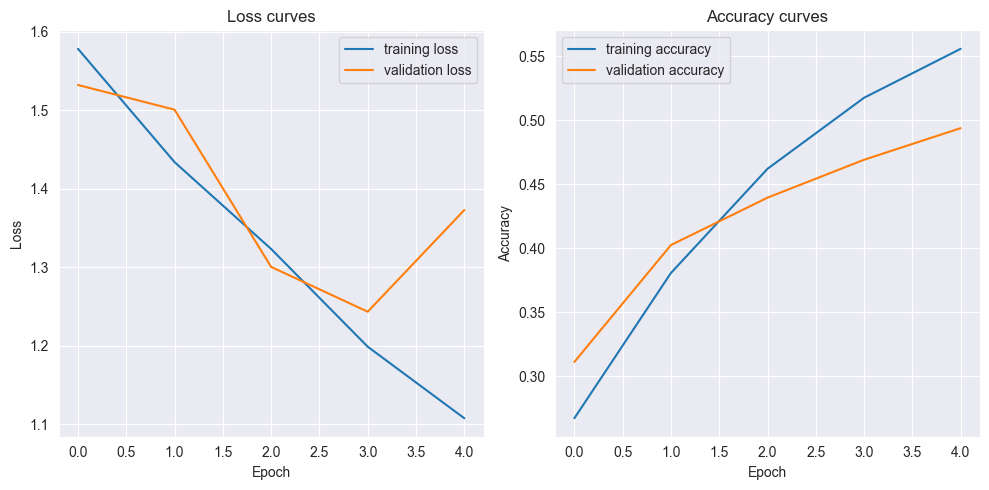

In [190]:
def plotLosses(history):
  # Create a figure and a grid of subplots with a single call
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
  # Plot the loss curves on the first subplot
  ax1.plot(history.history['loss'], label='training loss')
  ax1.plot(history.history['val_loss'], label='validation loss')
  ax1.set_title('Loss curves')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.legend()
  # Plot the accuracy curves on the second subplot
  ax2.plot(history.history['accuracy'], label='training accuracy')
  ax2.plot(history.history['val_accuracy'], label='validation accuracy')
  ax2.set_title('Accuracy curves')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend()
  # Adjust the spacing between subplots
  fig.tight_layout()
  # Show the figure
  plt.show()


plotLosses(history)

# Confusion Matrix

Confusion matrix visualizes models performance based on True Positives, True Negatives, False Positives, False Negatives. 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


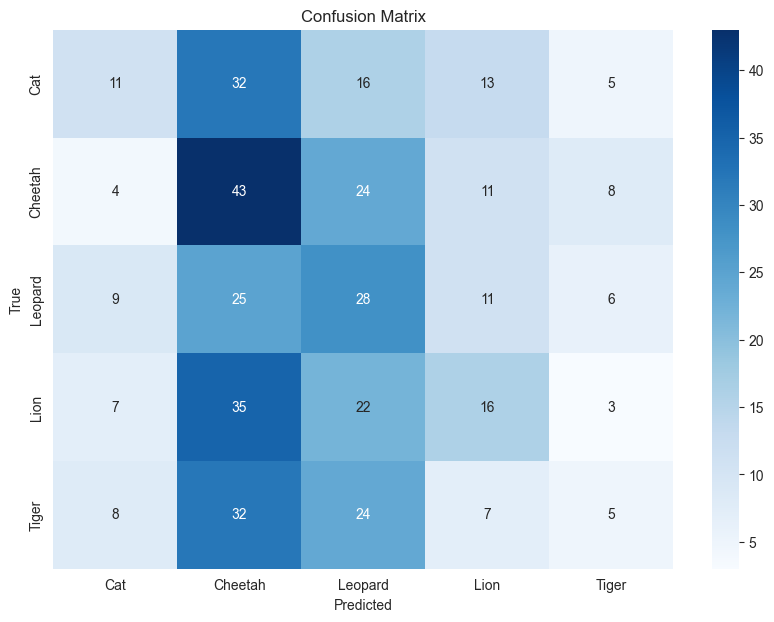

In [191]:


# Assume your model and test_ds are already defined and loaded correctly as per your code.
predictions = model.predict(validation_ds)
predicted_classes = np.argmax(predictions, axis=1)

# Extract true labels from the test dataset
true_labels = []
for images, labels in validation_ds:
    true_labels.extend(labels.numpy())

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [192]:
import pandas as pd
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)


file_paths = test_ds.file_paths
ids = [fp.split('\\')[-1].split('.')[0] for fp in file_paths]

submission_df = pd.DataFrame({
    'id': ids,
    'label': predicted_classes
})

submission_df.to_csv('submission.csv', index=False)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


# 2st MobileNet Model using Transfer Learning

Second model is fine-tuned model based on pre-trained MobileNet model 


In [193]:
# def preprocess_data(image, label):
#     return tf.keras.applications.mobilenet.preprocess_input(image), label
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# train_ds_resnet = train_ds.map(preprocess_data)
# val_ds_resnet = validation_ds.map(preprocess_data)
# test_ds_resnet = test_ds.map(preprocess_data)

base_model = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False


In [194]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


160

In [195]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [196]:
prediction_layer = tf.keras.layers.Dense(5, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [197]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = data_augmentation(x)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)